In [38]:
import argparse
from ddpm.denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Galaxies
import torch
import wandb

wandb.init()

%load_ext autoreload
%autoreload 2

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
torch.cuda.is_available()

True

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [28]:
model = Unet(
    dim = 128,
    dim_mults = (1, 2, 4)
).to(device=DEVICE)

diffusion = GaussianDiffusion(
    model,
    image_size =128,
    timesteps = 200,
    loss_type = 'l2'
).to(device=DEVICE)

In [29]:
args = {'dataset': 'desi_bgs'}
wandb.watch(diffusion, log_freq=100)

[]

In [94]:
trainer = Trainer(
    diffusion,
    '/pscratch/sd/s/sihany/desiimages/',
    logdir = '/pscratch/sd/s/sihany/logs/desi/',
    image_size = 128,
    train_batch_size = 16,
    train_lr = 1e-5,
    train_num_steps = 2000,         # total training steps
    gradient_accumulate_every = 4,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    step_start_ema = 1000,
    save_every = 100,
    num_workers=16,
    # rank = [0, 1, 2]
)

In [ ]:
trainer.train()

sampling loop time step: 100%|██████████| 200/200 [00:08<00:00, 23.81it/s]

loss = 0.1412743628025055:  33%|███▎      | 655/2000 [05:36<11:12,  2.00it/s]  

In [83]:
# sample and plot

all_images = diffusion.sample(256, batch_size = 6)
all_images = (all_images + 1)/2
# all_images = list(map(lambda x: (x - 0)/(255 - 0), all_images))
all_images = torch.flip(all_images, dims=[1])*255 # map channels correctly for imout


[autoreload of ddpm.denoising_diffusion_pytorch failed: Traceback (most recent call last):
  File "/global/common/software/desi/users/sihany/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/global/common/software/desi/users/sihany/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/global/common/software/desi/users/sihany/anaconda3/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed


(array([1.100e+01, 1.660e+02, 1.225e+03, 4.613e+03, 6.213e+03, 3.243e+03,
        7.820e+02, 1.110e+02, 1.700e+01, 3.000e+00]),
 array([ 23.82921982,  40.49458313,  57.15994644,  73.82530975,
         90.49066925, 107.15603638, 123.82139587, 140.48675537,
        157.15213013, 173.81748962, 190.48284912]),
 <BarContainer object of 10 artists>)

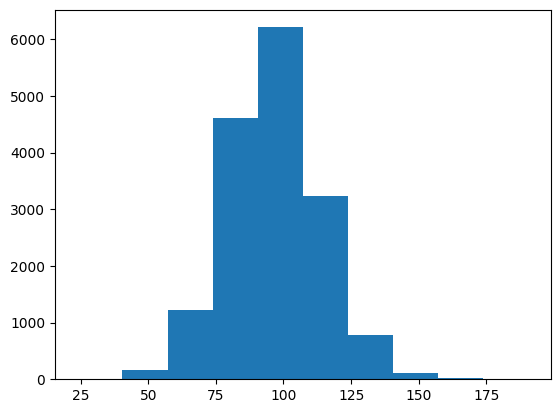

In [84]:
import matplotlib.pyplot as plt
plt.hist(all_images[0].cpu()[0].flatten())

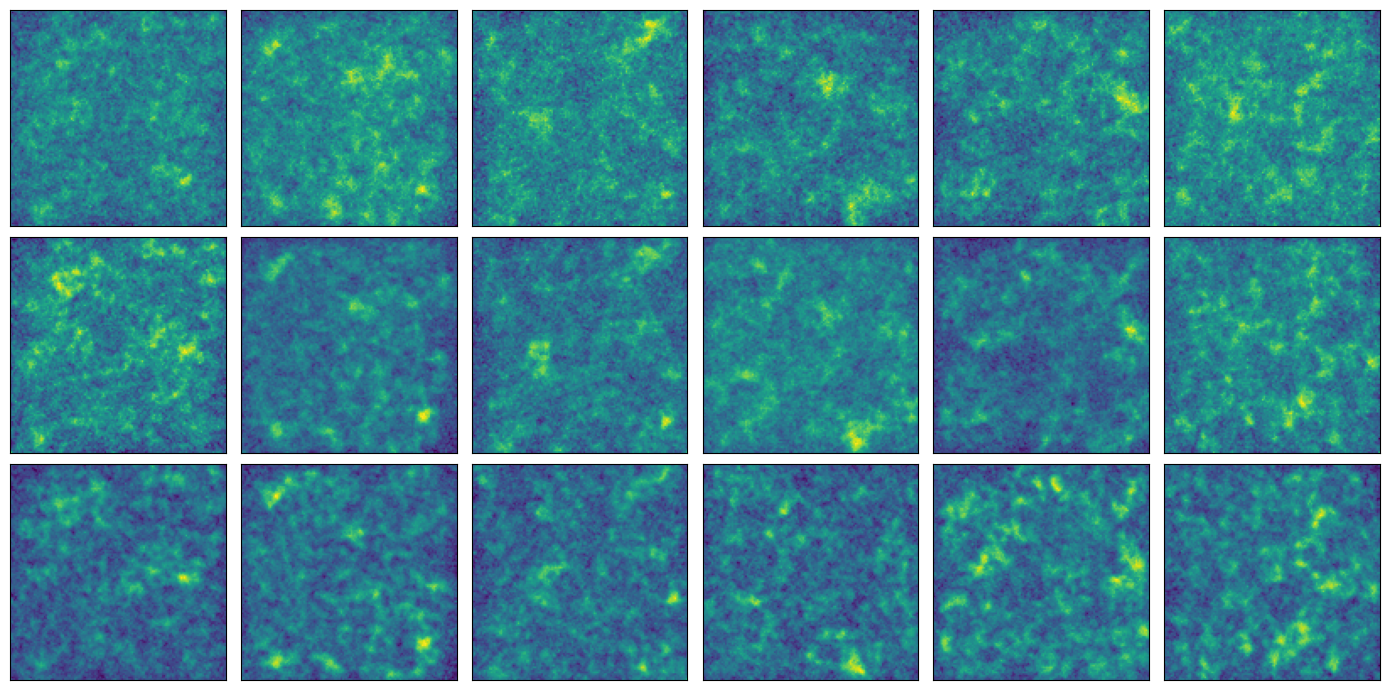

In [85]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (14, 7), ncols = 6, nrows = 3)
for i in range(6):
    # a = fits.open(fi)[0].data
    for jj in range(3):
        ax[jj][i].imshow(all_images[i].cpu()[jj,:,:])
        ax[jj][i].set_xticks([])
        ax[jj][i].set_yticks([])
    
plt.tight_layout()

# check images

In [44]:
fns = glob('/pscratch/sd/s/sihany/desiimages/*.npy')
np.load(fns[0]).shape

(3, 128, 128)

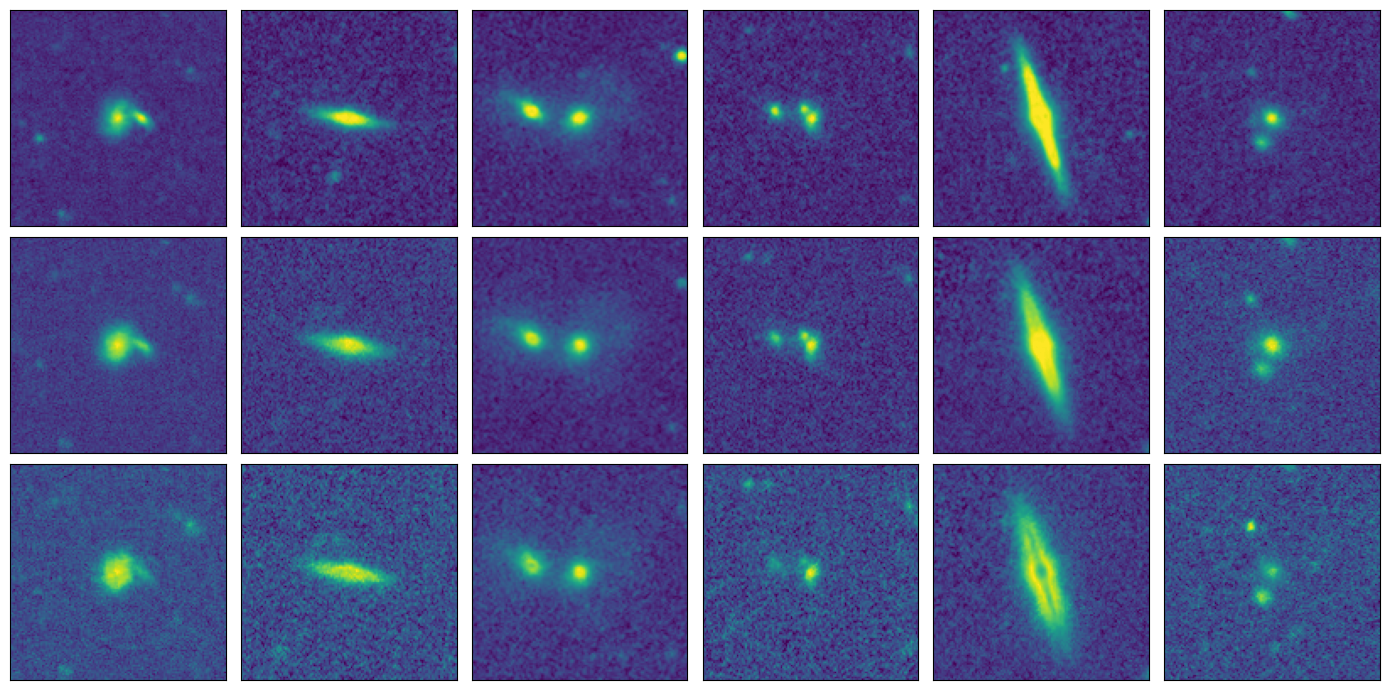

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from astropy.io import fits
from glob import glob
import random

catalog = fits.open('/pscratch/sd/v/virajvm/sandy_imgs/jura_bgs_N_20000.fits')[1].data
ids = catalog['TARGETID']
maskrflux = catalog['FLUX_R'] > 0
ids_sel = ids[maskrflux]

# fns = [f'/pscratch/sd/v/virajvm/sandy_imgs/grz_cutouts_jpg/grz_dr9_id_{eid}.jpg' for eid in ids_sel]

fns = glob('/pscratch/sd/s/sihany/desiimages/*.npy')

rfns = random.sample(fns, 6)

fig, ax = plt.subplots(figsize = (14, 7), ncols = 6, nrows = 3)
for i, fi in enumerate(rfns):
    # a = fits.open(fi)[0].data
    a = np.load(fi)
    # print(a, np.max(a), np.min(a))
    for jj in range(3):
        ax[jj][i].imshow(a[jj, :,:])
        ax[jj][i].set_xticks([])
        ax[jj][i].set_yticks([])
    
plt.tight_layout()


In [26]:
a

NameError: name 'a' is not defined

In [6]:
fns = [f'/pscratch/sd/v/virajvm/sandy_imgs/grz_cutouts_jpg/grz_dr9_id_39628065248123413.fits' for ename in [1,2,3]]

In [11]:
from os.path import basename
basename(fns[0])[11:-5]

'39628065248123413'